# AOMA on HDF5 data

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
import dataloader_halogaland.dataloader as dl
from dataloader_halogaland.plot import welch_plot, stabilization_diagram
import os
import koma.oma, koma.plot
import koma.clustering

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
#path = '../Data/Halogaland_fifth_try.hdf5'
analysis_length = 30 #minutes
cutoff_frequency = 1 #Hz

loader= loader= dl.HDF5_dataloader(os.getcwd()+'/../../../../../../../Volumes/LaCie/Halogaland_sixth_try.hdf5')

Available accelerometers: ['A01-1', 'A03-1', 'A03-2', 'A04-1', 'A04-2', 'A05-1', 'A05-2', 'A06-1', 'A06-2', 'A06-3', 'A06-4', 'A07-1', 'A07-2', 'A08-1', 'A08-2', 'A08-3', 'A08-4', 'A09-1', 'A09-2', 'A10-1', 'A10-2', 'A11-1']


In [6]:
acc = loader.load_all_acceleration_data(loader.periods[12], preprosess=True, cutoff_frequency=cutoff_frequency, filter_order=10)
print(acc.shape)
acc = acc[:2*cutoff_frequency*60*analysis_length,:]
print(acc.shape)

(57600, 66)
(3600, 66)


### Cov-SSI

In [7]:
i = 100
s = 6
fs = 2
orders = np.arange(2, 150+2, 2)

stabcrit = {'freq': 0.05, 'damping': 0.1, 'mac': 0.1} # Default

*** Covariance-driven SSI algorithm for OMA ***
> Establishing Hankel/Toeplitz matrices
  >> Correlation estimation
  >> Matrix stacking
> Establishing weighting matrices
  >> Weighting requested: NONE
> Computing SVD
> Computing state matrix for each order to establish modes
> Computation completed


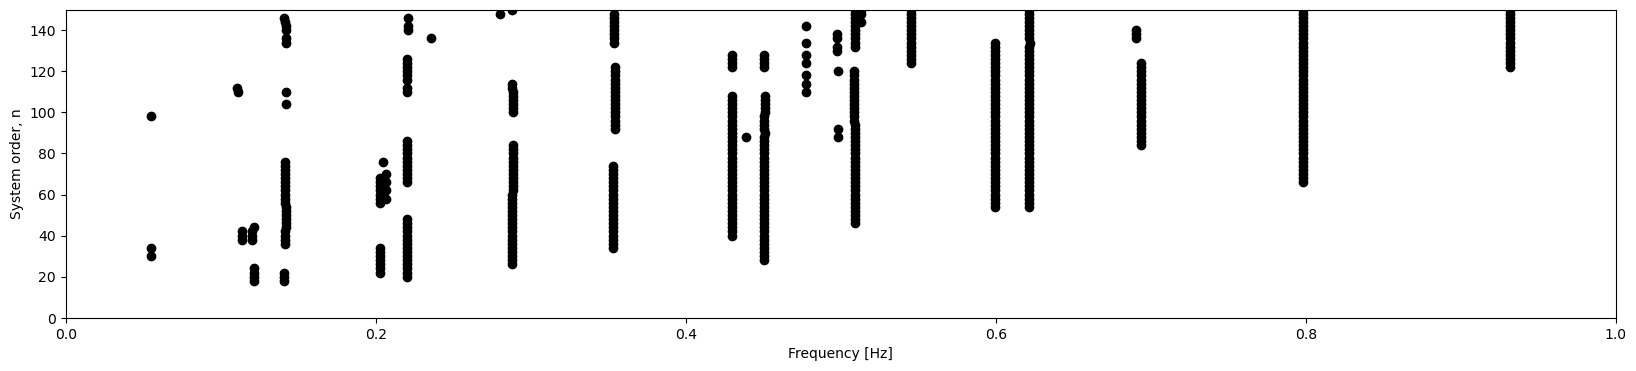

In [8]:
from python_appendix import OMA_functions as OMA
#Cov-SSI call
#lambd, phi = koma.oma.covssi(acc[:18000,:], fs, i, orders, showinfo=True) # find poles by Cov-SSI
#lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, stabcrit=stabcrit, indicator='mac') # Stable poles

#print(lambd_stab.shape)
#print(phi_stab.shape)

f_n_sort, ksi_sort, phi_sort, fig, lambd_stab, phi_stab, orders_stab = OMA.modalParamOMA(acc, fs, orders, i, s, stabcrit=stabcrit, autoSpectrum=False)

In [9]:
print((orders_stab).shape)
print((lambd_stab).shape)
print((phi_stab).shape)

(526,)
(526,)
(66, 526)


In [11]:
print(type(orders_stab))
#print(lambd_stab[0])
print(phi_stab.shape)

<class 'numpy.ndarray'>
(66, 526)


In [6]:
#Pole clustering
pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':0.7, 'lambda_imag': 0.5})
prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

#plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/2/np.pi, order_auto).savefig("results/realization_" + str(j) + ".jpg")

xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: divide by zero encountered in divide
  diff = (arr1-arr2)/scaling
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/clustering.py:46: RuntimeWarning: invalid value encountered in divide
  diff = (arr1-arr2)/scaling


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_46291/1995549658.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc, fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)


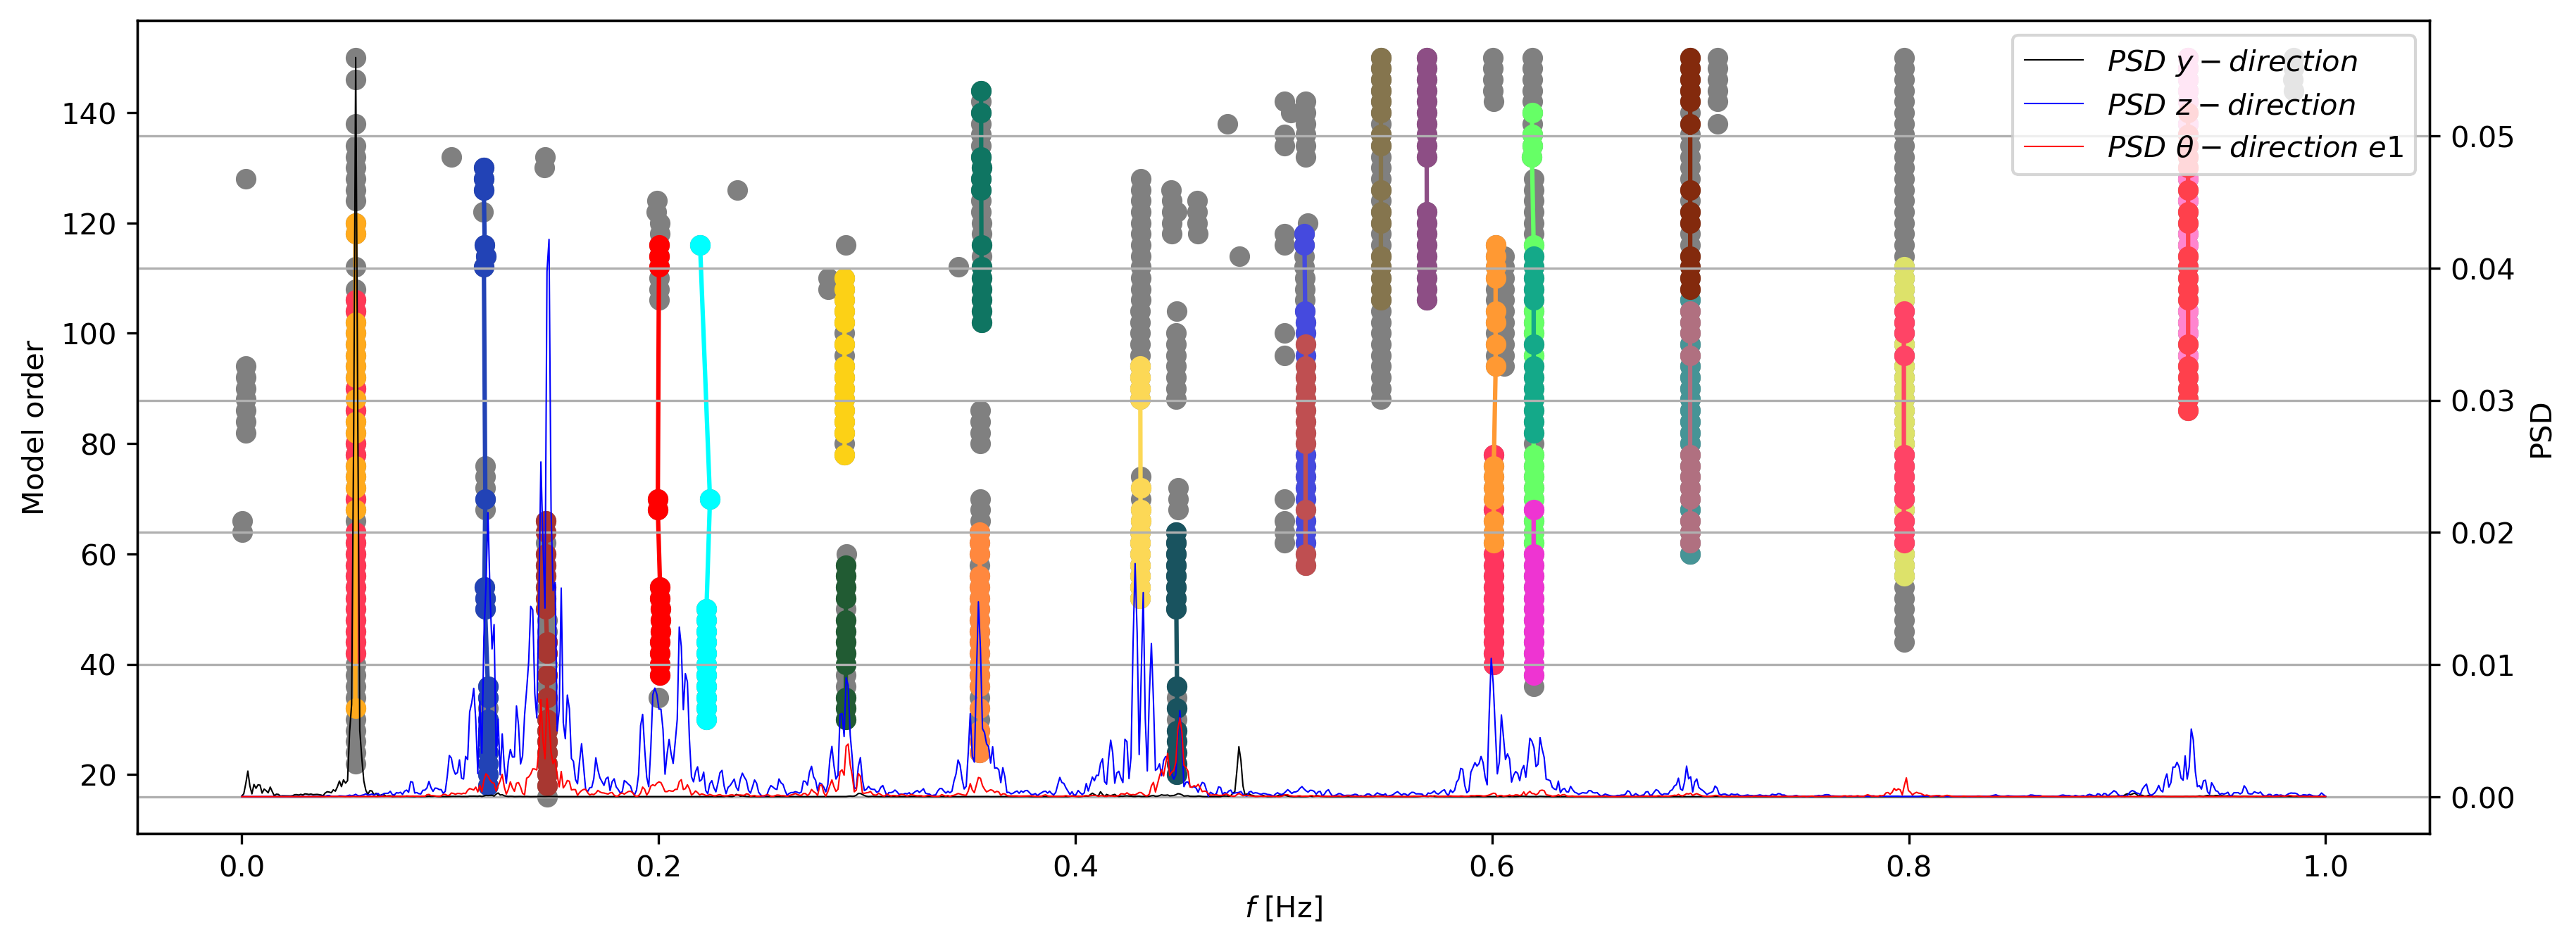

In [7]:
stab_diag = stabilization_diagram(acc, fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambd_stab)/2/np.pi, all_orders=orders_stab)
plt.savefig("stabilization_diagram.jpg")

In [8]:
# Print table
import pandas as pd
res_data = np.vstack([fn_mean, 100*xi_mean]).T
results = pd.DataFrame(res_data, columns=['$f_n$ [Hz]', r'$\xi$ [%]'])
results

,$f_n$ [Hz],$\xi$ [%]
0,0.054536,0.994451
1,0.054538,0.991357
2,0.117322,5.520388
3,0.146272,2.720443
4,0.200536,2.472915
5,0.222778,2.835533
6,0.289266,1.207739
7,0.289909,1.140440
8,0.354133,1.286408
9,0.354959,0.888217


In [9]:
from python_appendix import OMA_functions as OMA

# Group only a selected quantity (e.g. indices)
lambd_used, phi_used, order_stab_used, group_ixs, all_single_ix, probs = pole_clusterer.postprocess(prob_threshold=prob_threshold)

grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)   # or the phis only

print(len(grouped_phis))

phi_extracted = np.zeros((len(grouped_phis), len(loader.acceleration_sensors)*3))
print(phi_extracted.shape)

for i in range(len(grouped_phis)):
    for j in range(np.shape(grouped_phis[i])[0]):
       phi_extracted[i,j] = (np.real(np.mean(grouped_phis[i][j])))

phi_extracted = phi_extracted.transpose()
print(phi_extracted)
print(phi_extracted.shape)

28
(28, 57)
[[ 6.85172804e-03  7.25739368e-03 -1.30977819e-02 ...  2.04877129e-02
  -4.68568154e-03 -7.29579443e-03]
 [-1.75714021e-02 -7.30849899e-03 -6.33422490e-02 ...  1.74121312e-02
   2.87995279e-02  3.16512003e-02]
 [ 4.70335078e-02  4.26207948e-02 -5.48992092e-02 ...  2.15436915e-02
  -2.28068916e-02 -1.91594697e-02]
 ...
 [ 5.51568949e-02  1.97147168e-02 -4.63450608e-01 ... -9.78943801e-01
   6.34415512e-01  6.72877171e-01]
 [ 8.39916017e-02  7.00515026e-02 -8.92891278e-01 ...  5.31685640e-03
  -4.66166453e-01 -4.89238254e-01]
 [ 4.43038715e-02  3.73928989e-02 -8.99844830e-01 ... -2.39054491e-04
   4.90370803e-01  5.11414361e-01]]
(57, 28)


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/python_appendix/OMA_functions.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(4, 1, figsize=(7,10))


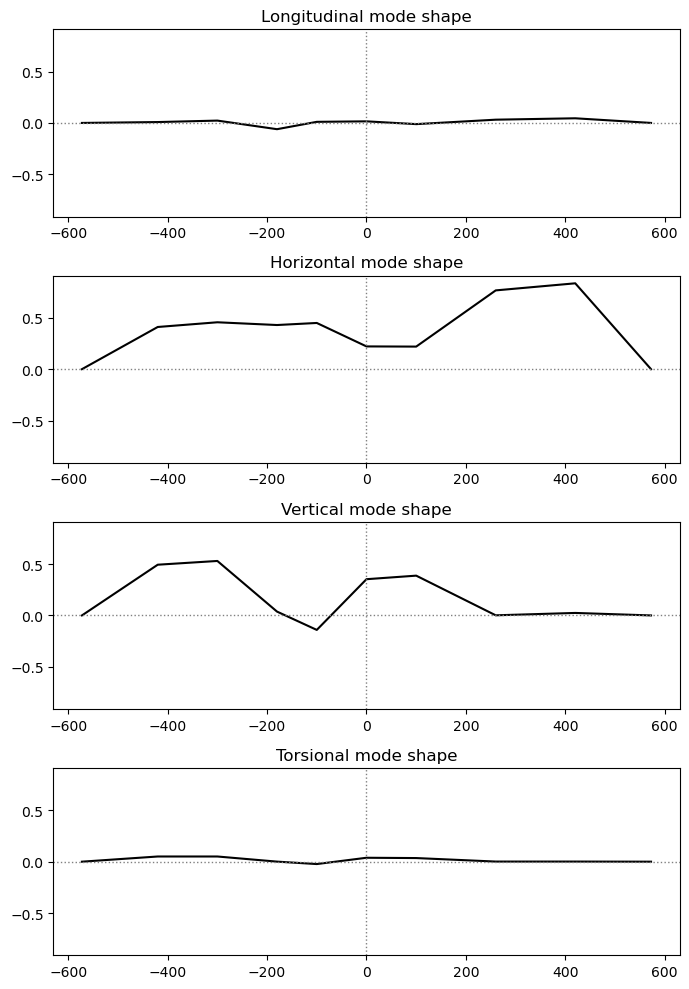

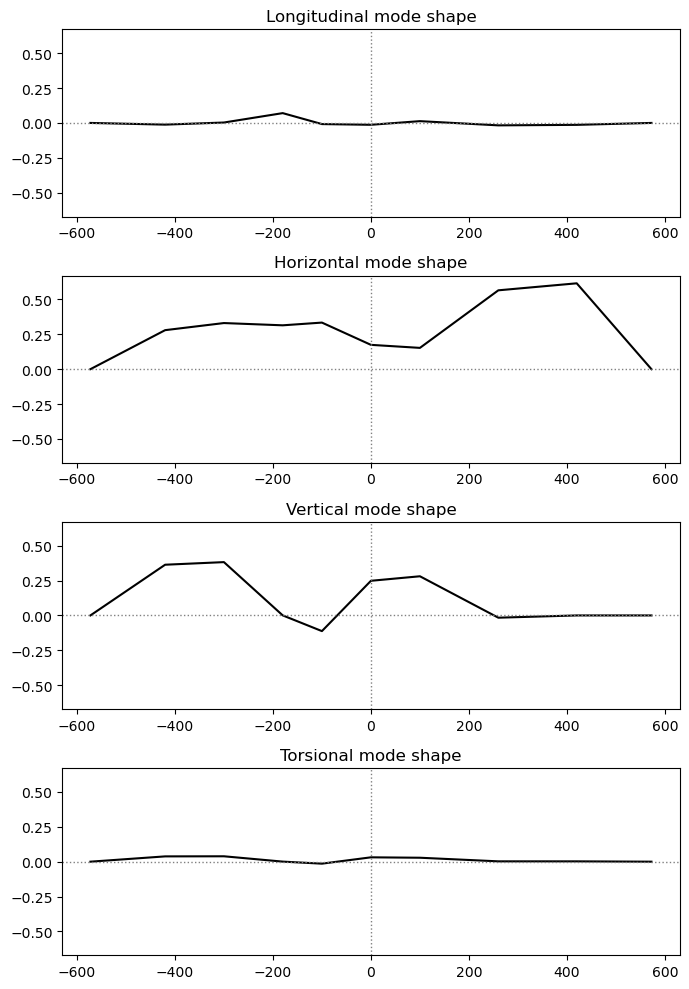

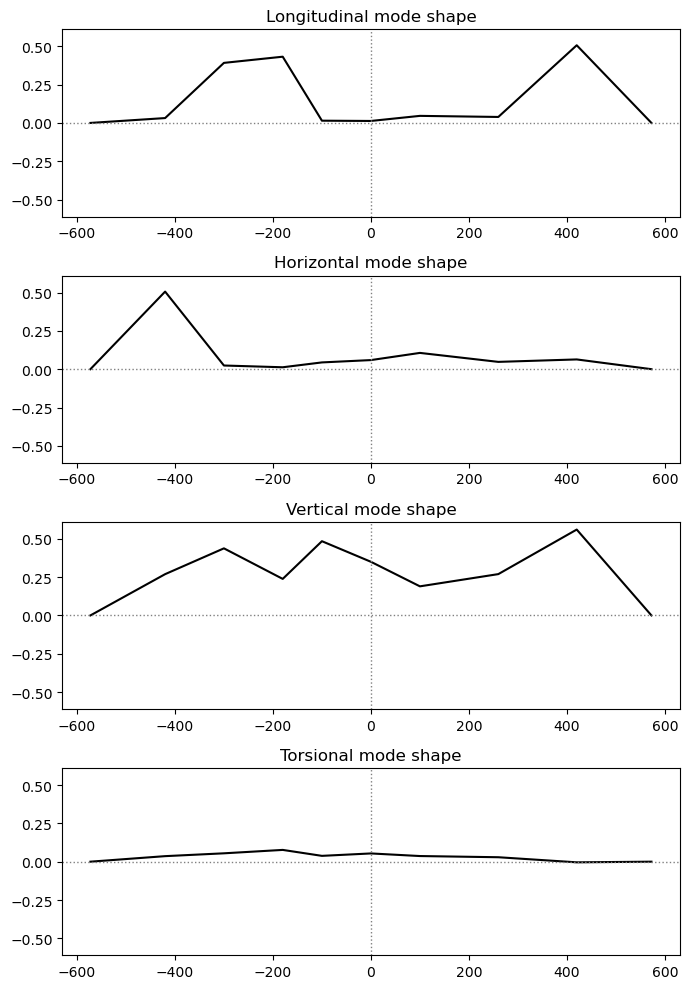

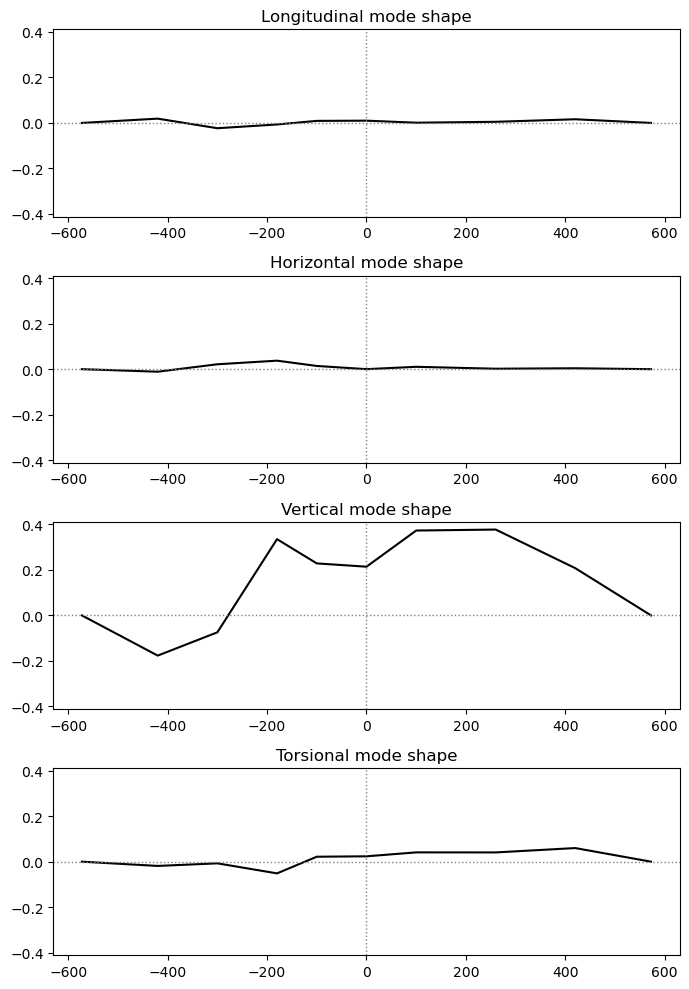

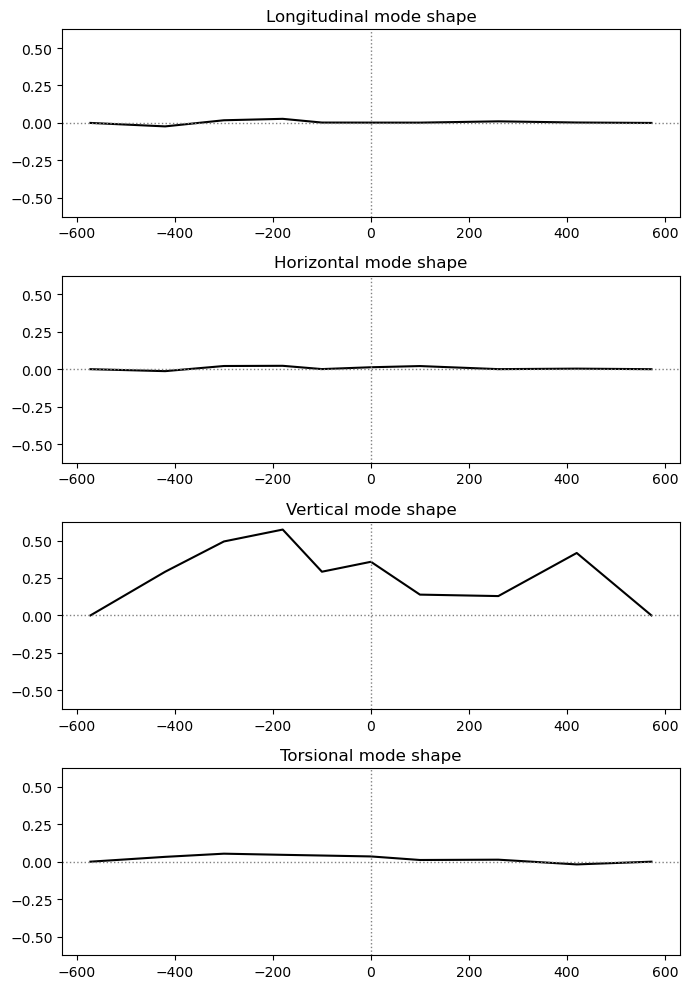

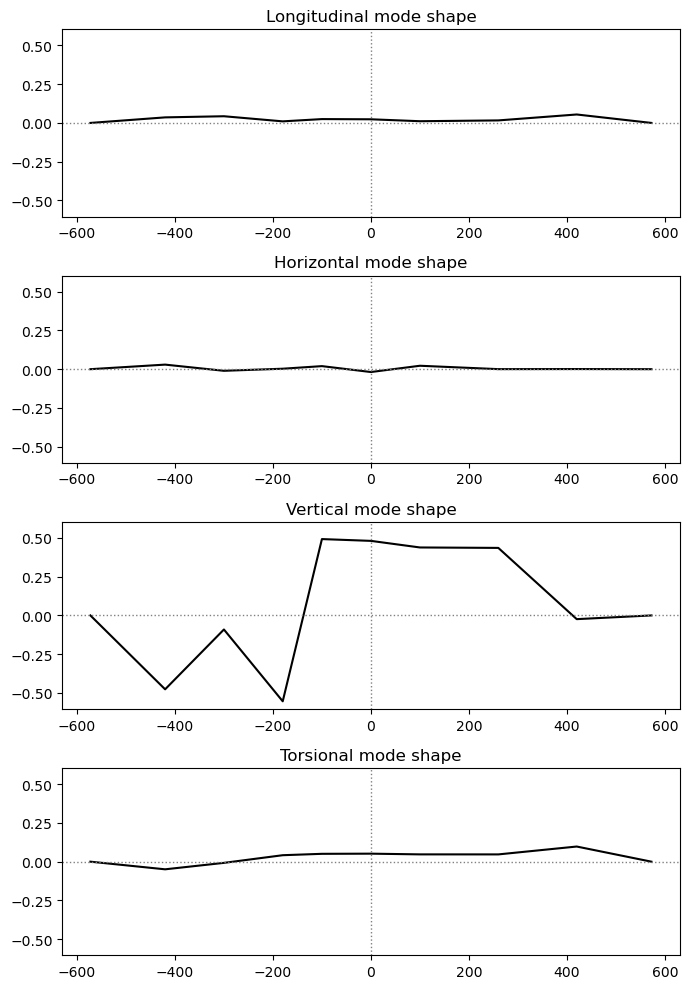

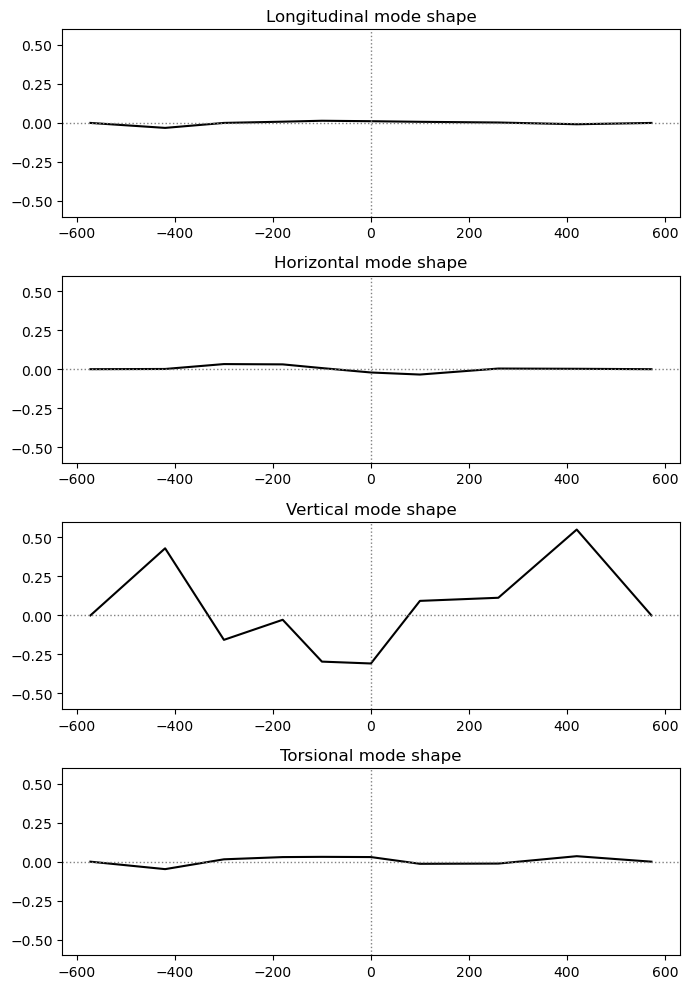

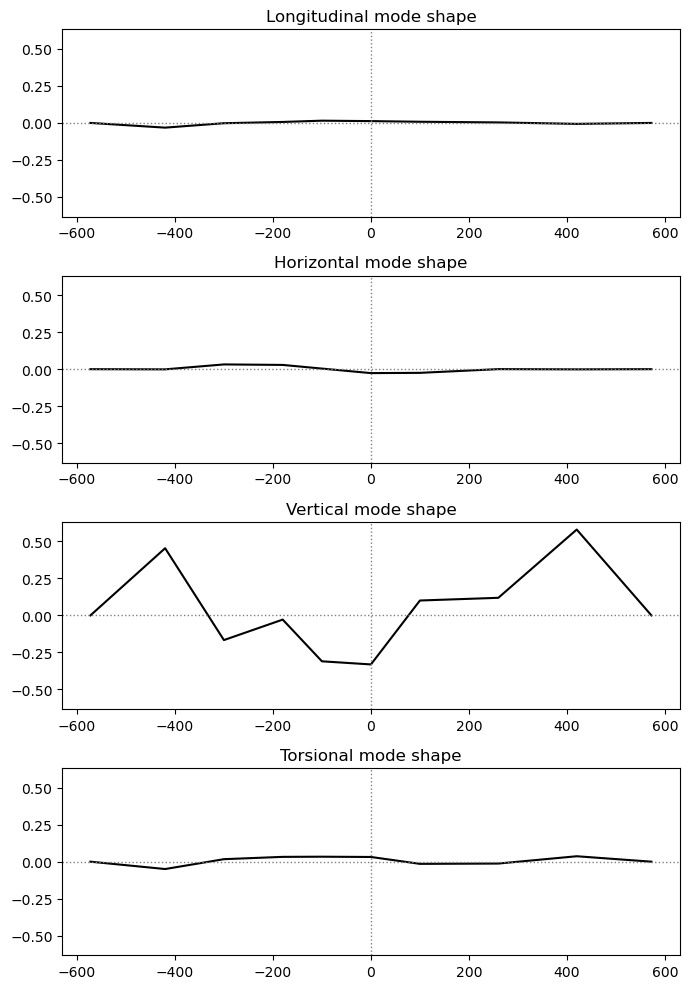

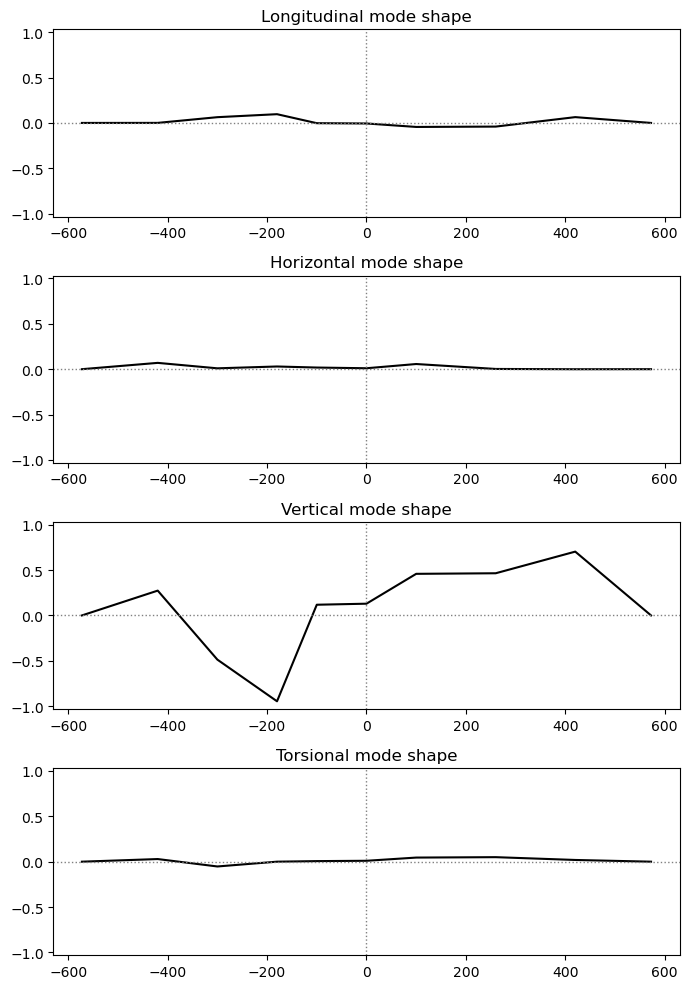

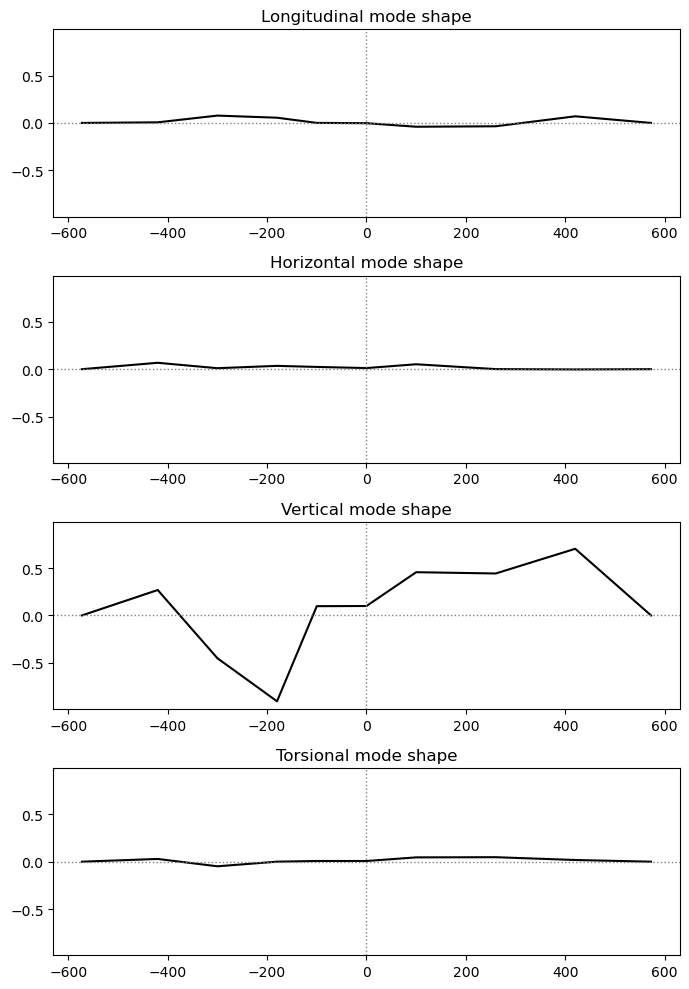

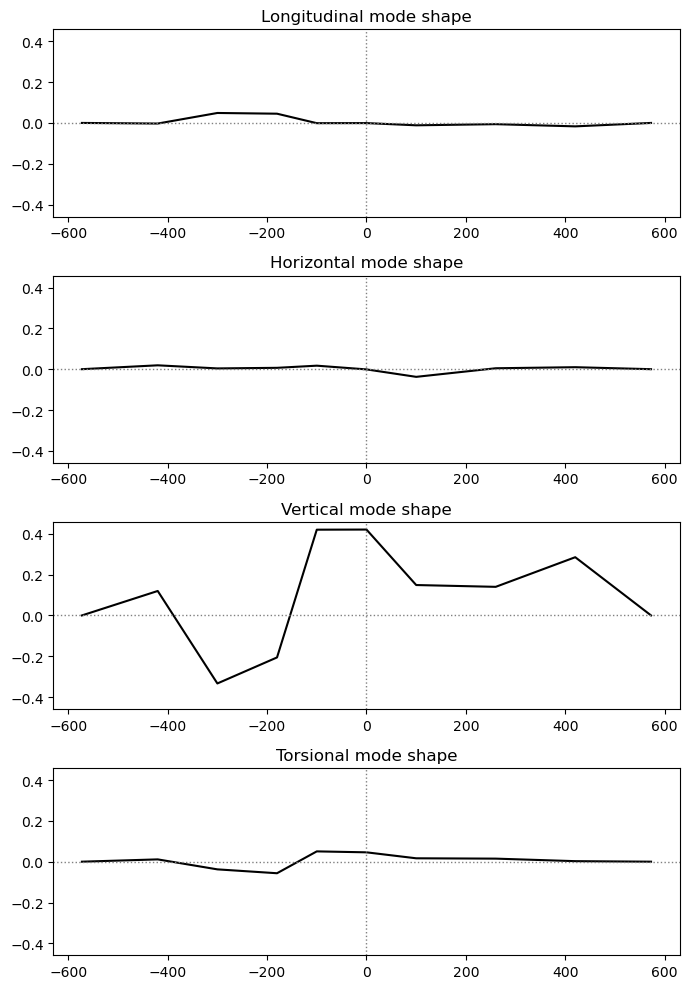

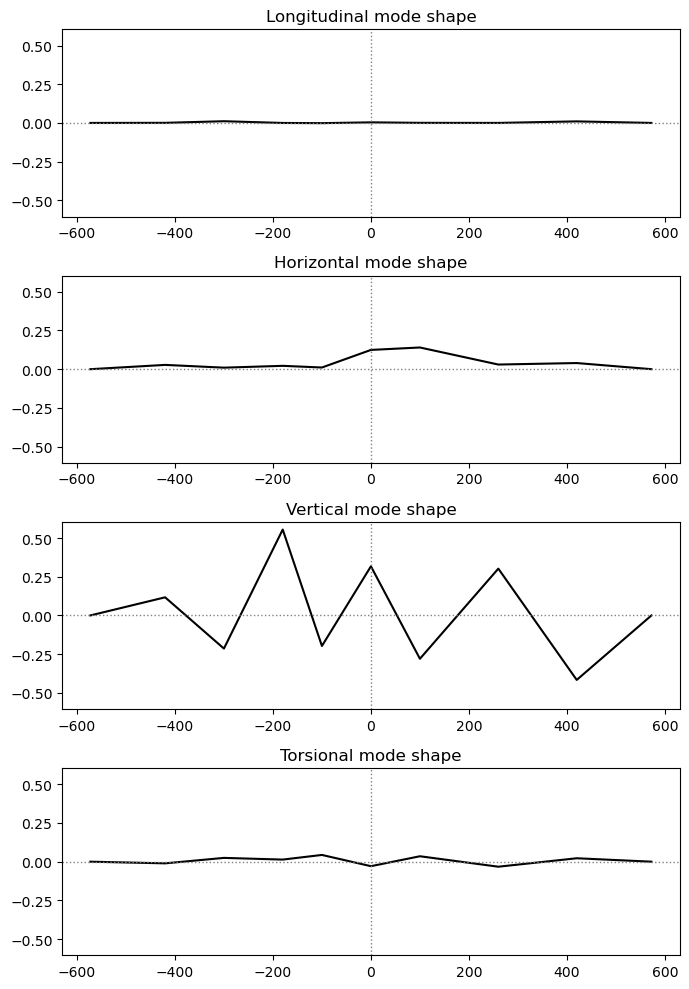

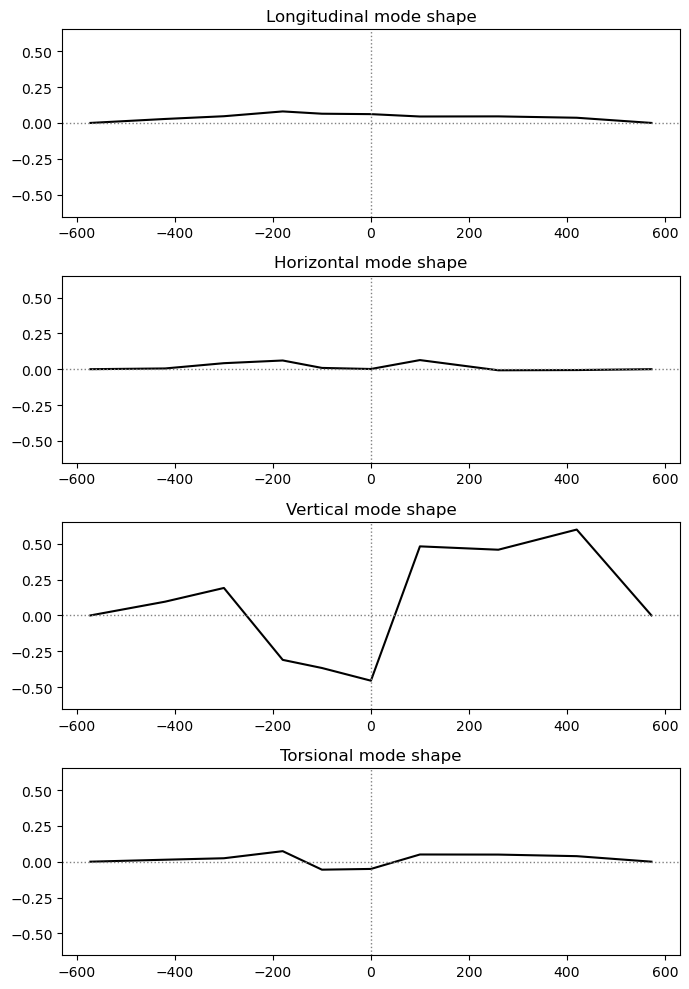

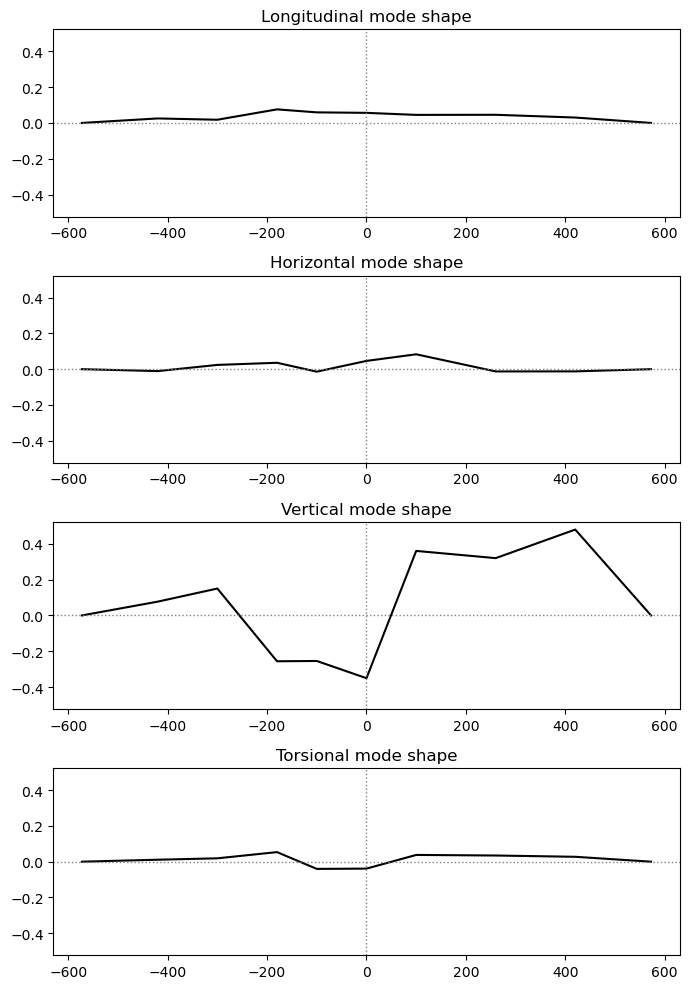

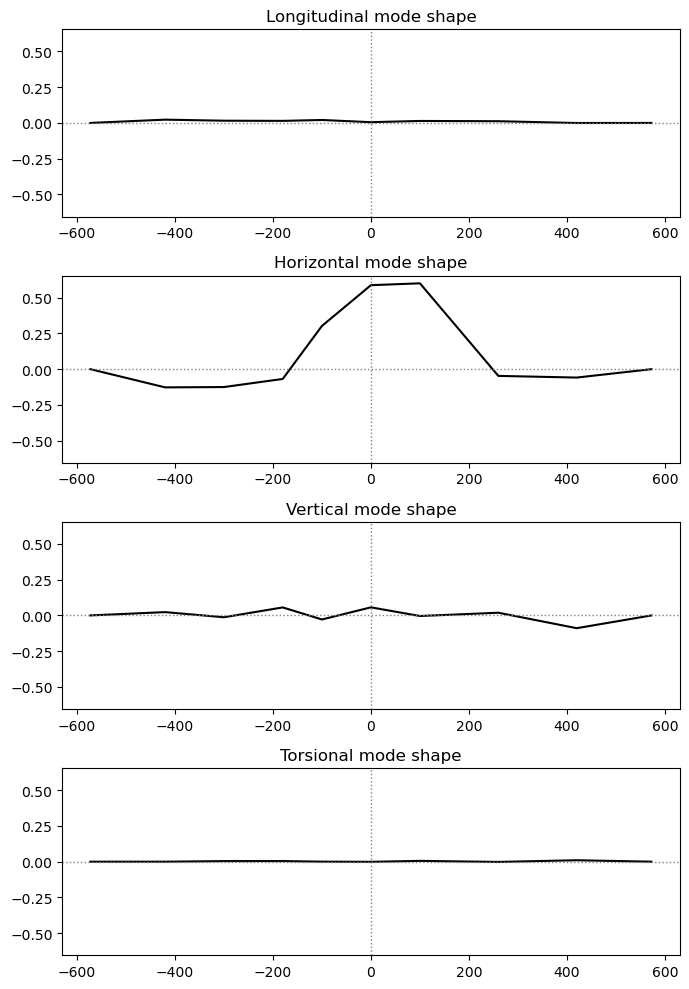

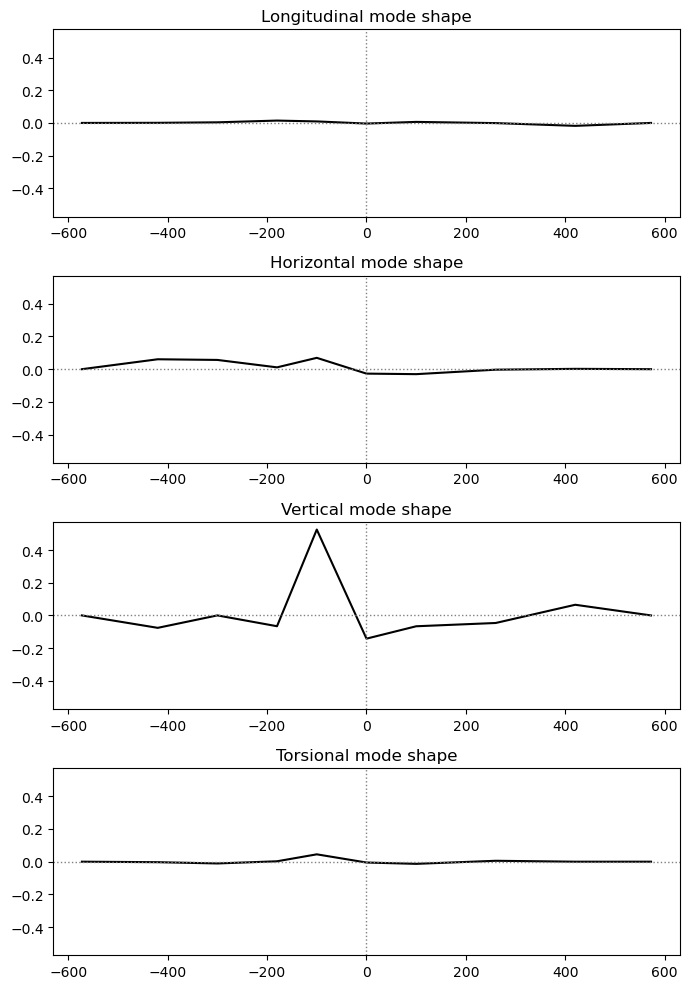

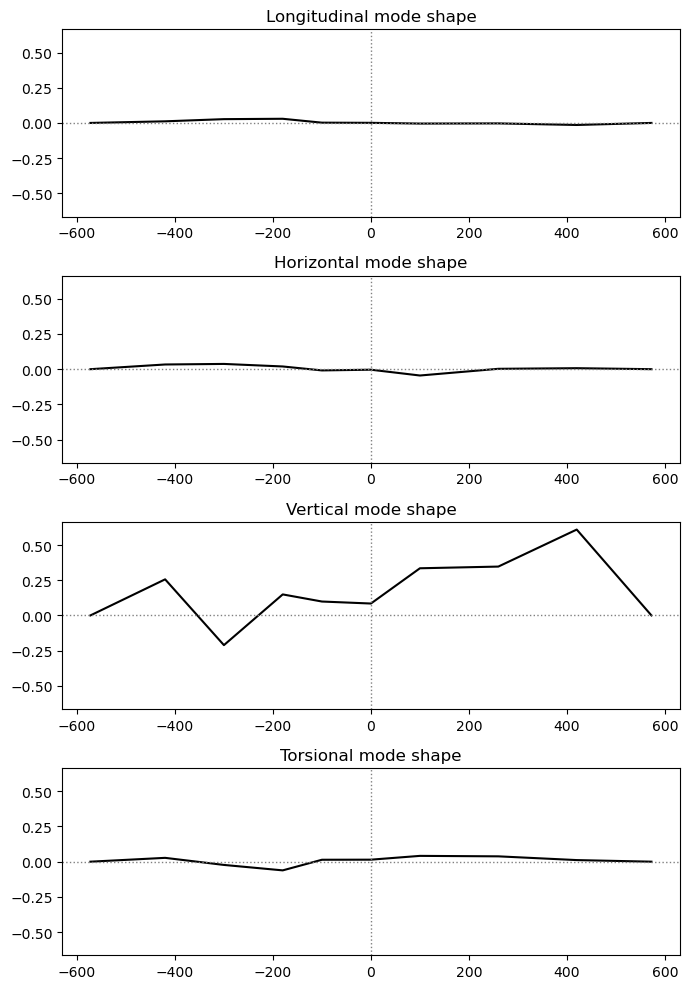

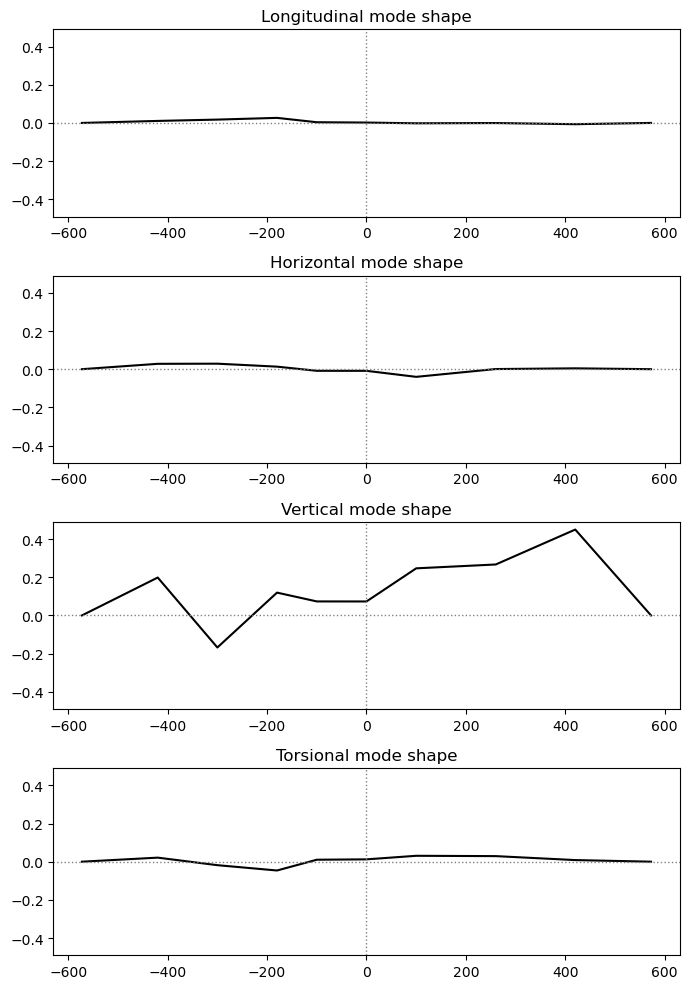

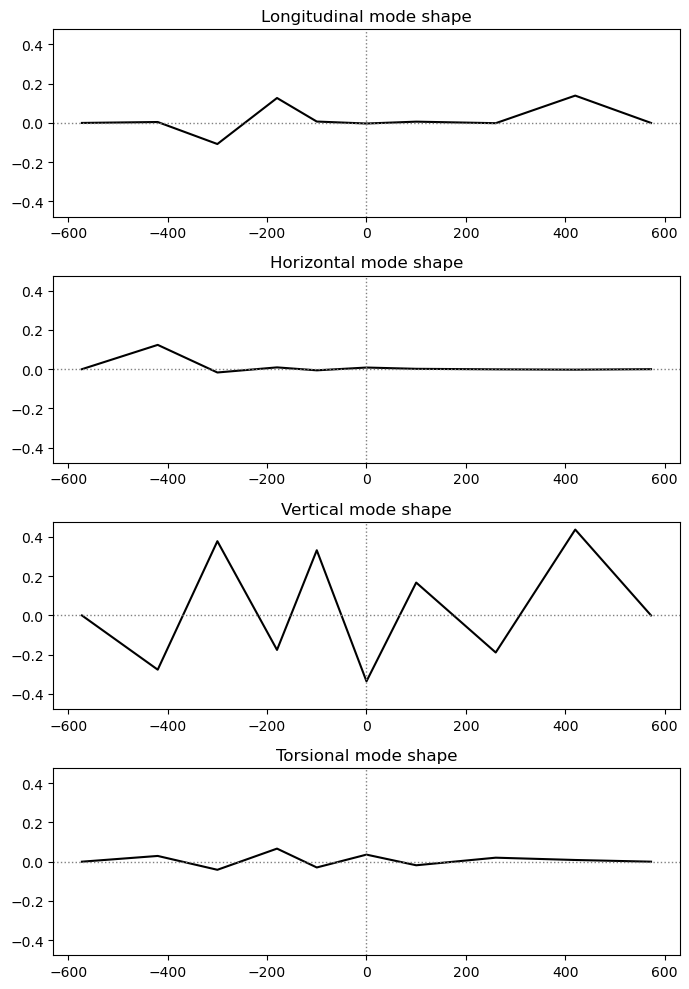

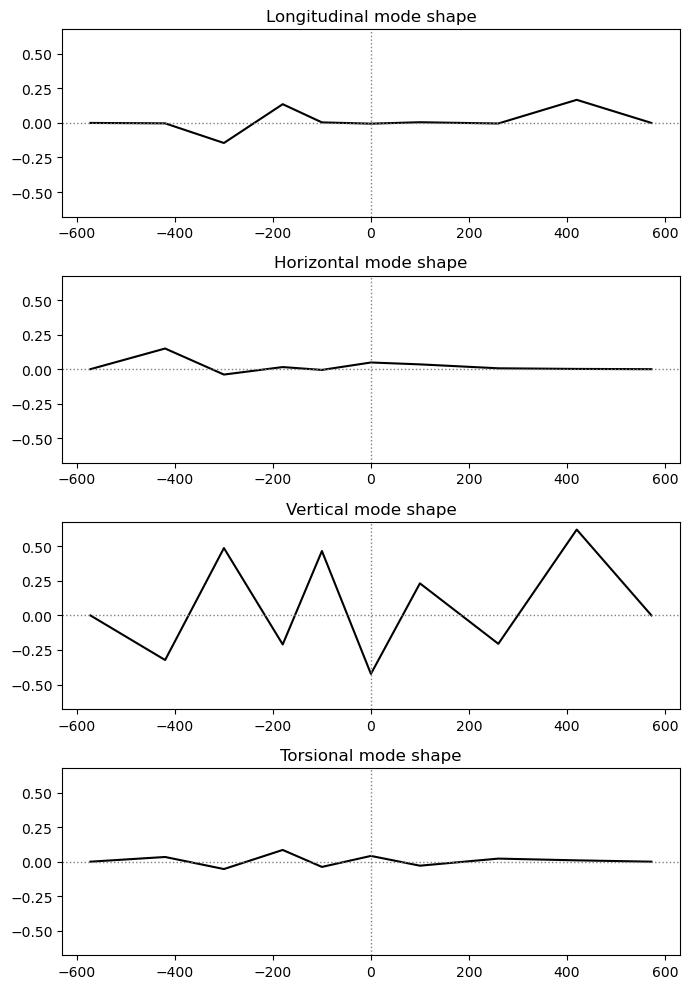

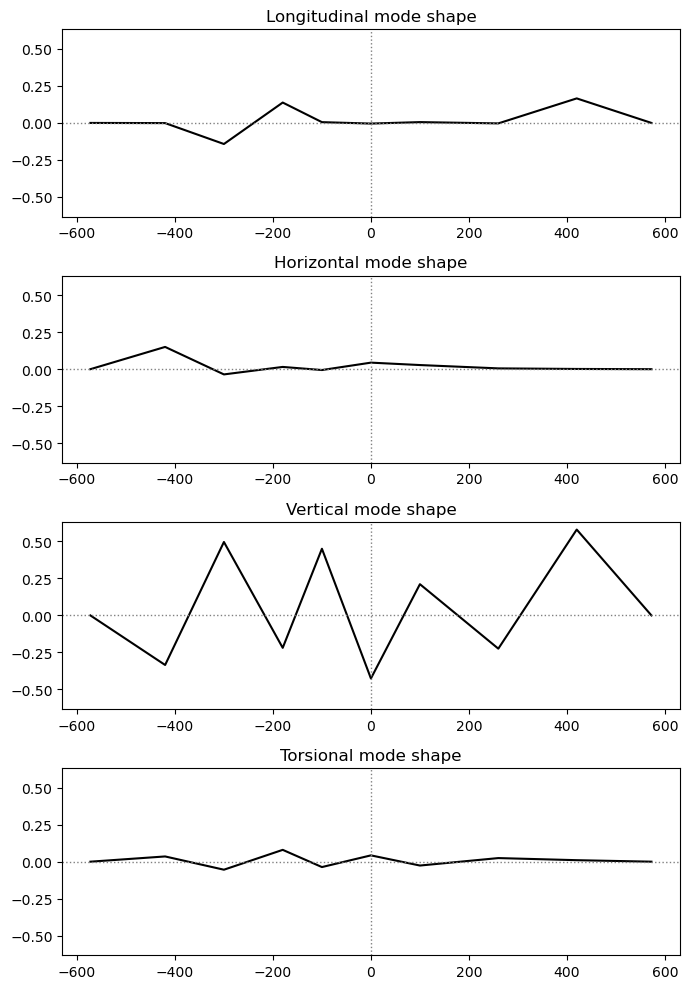

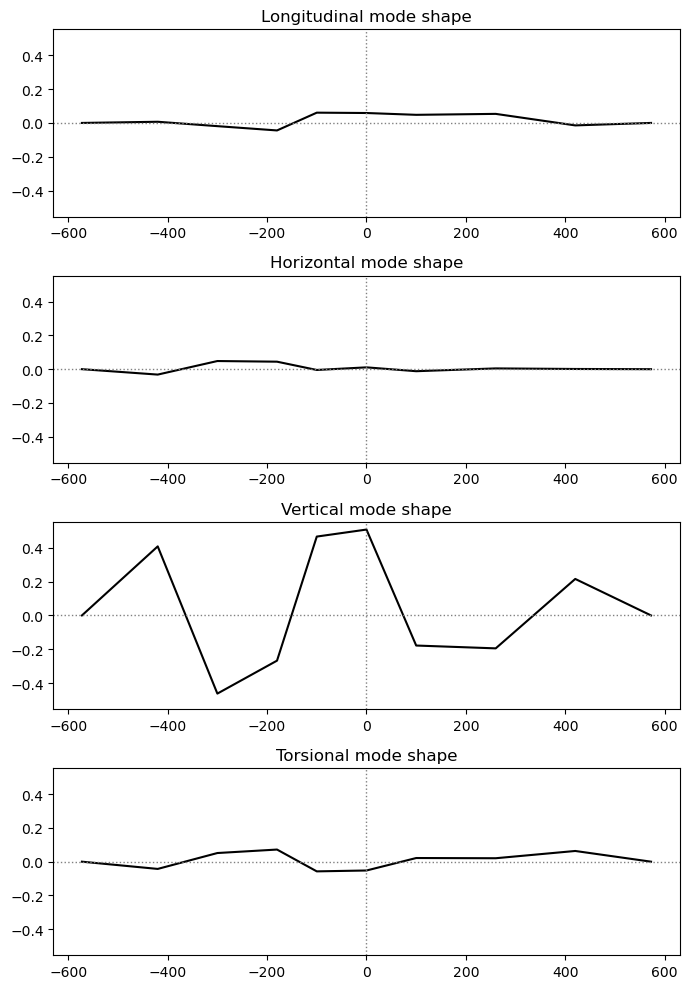

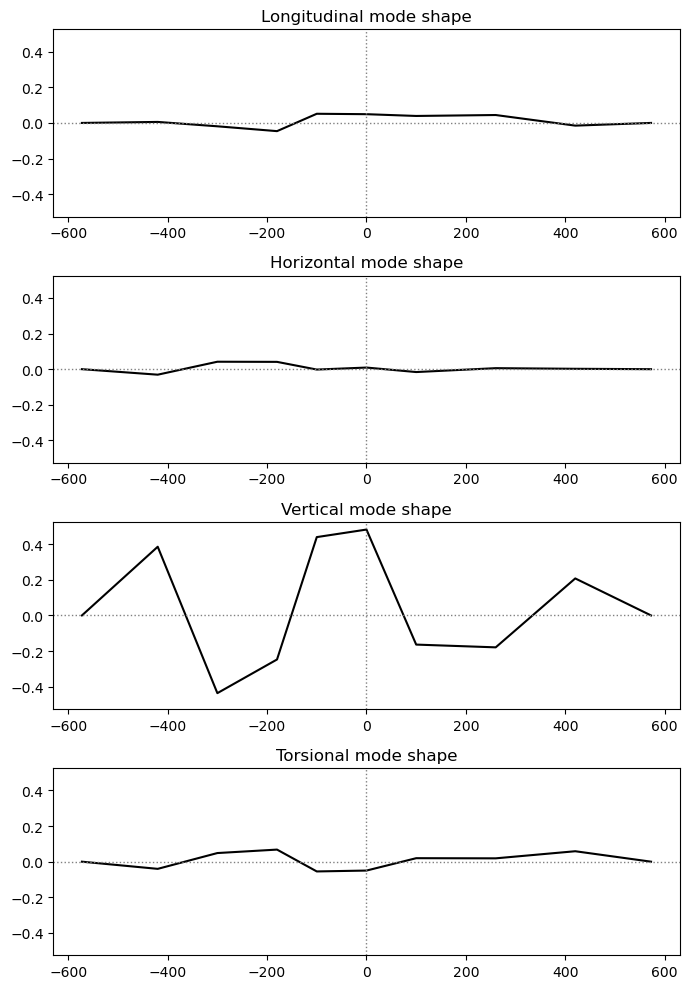

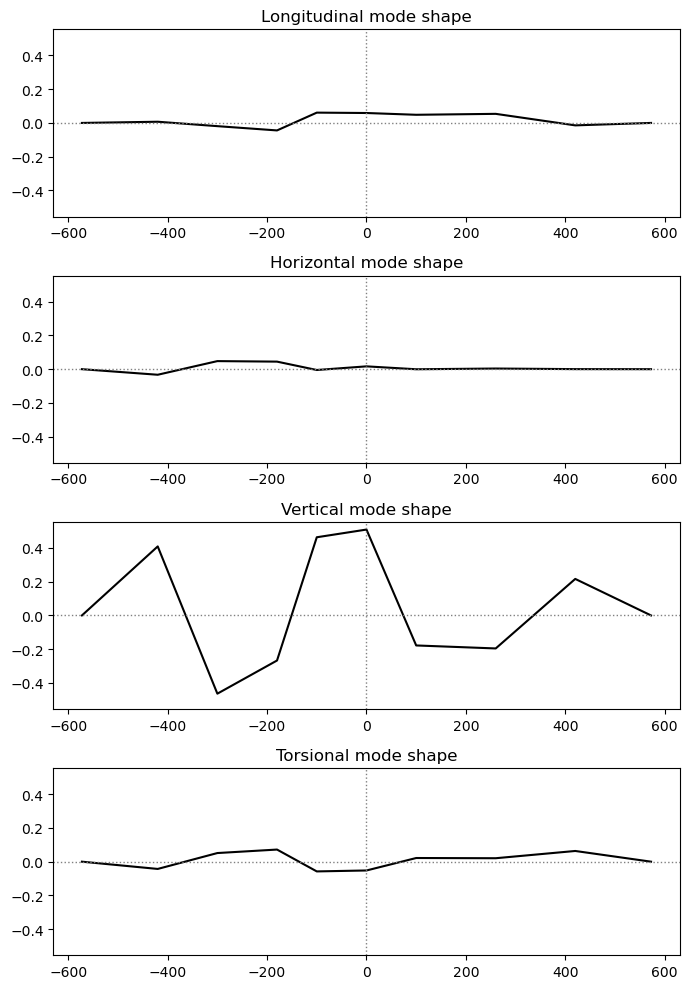

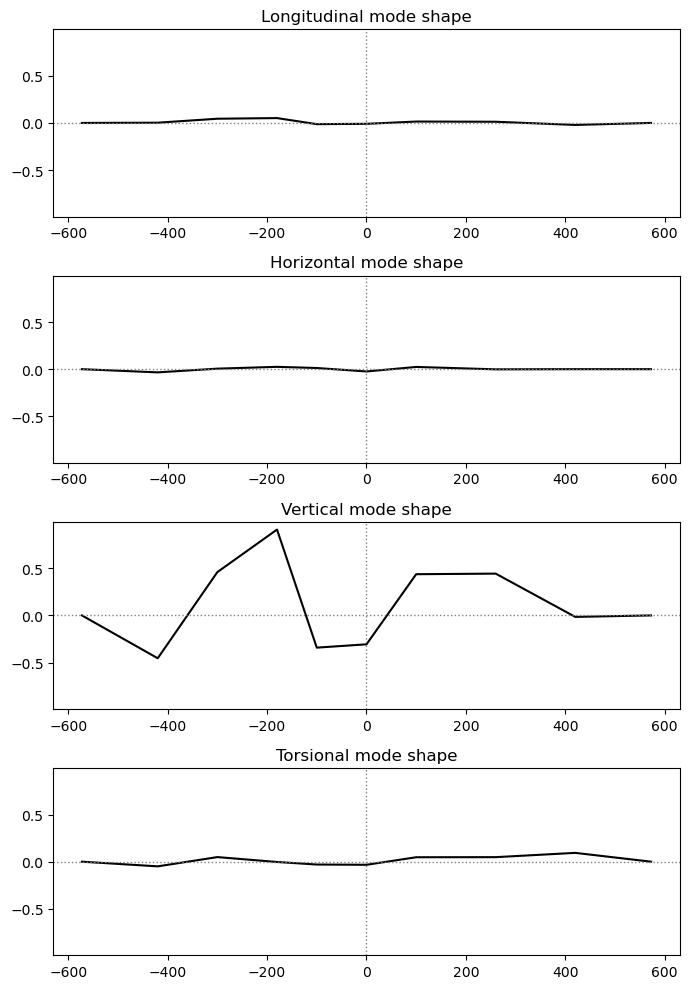

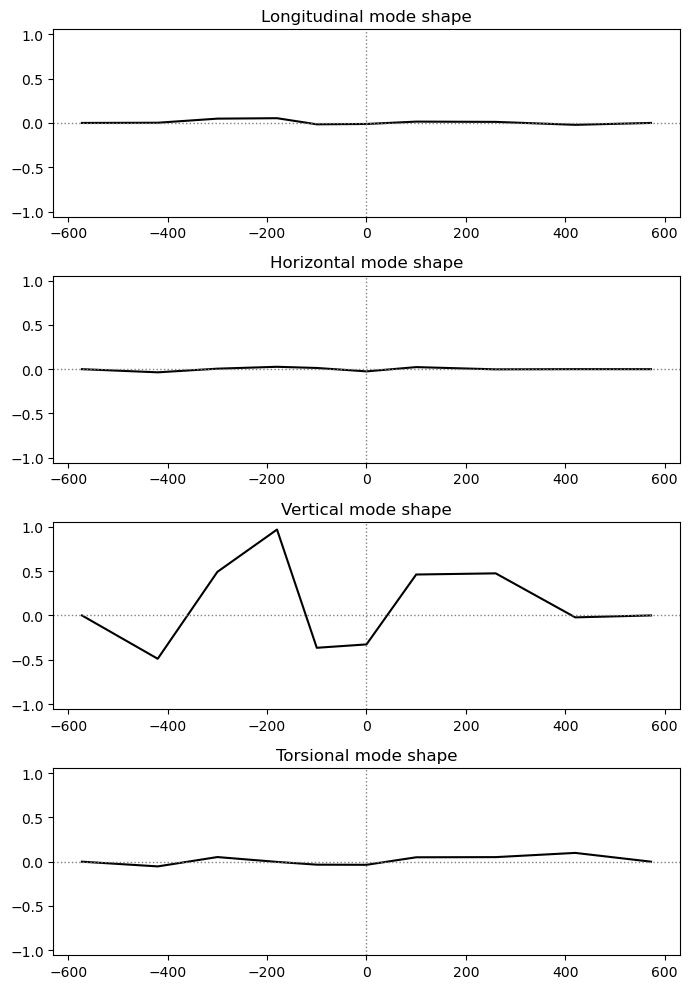

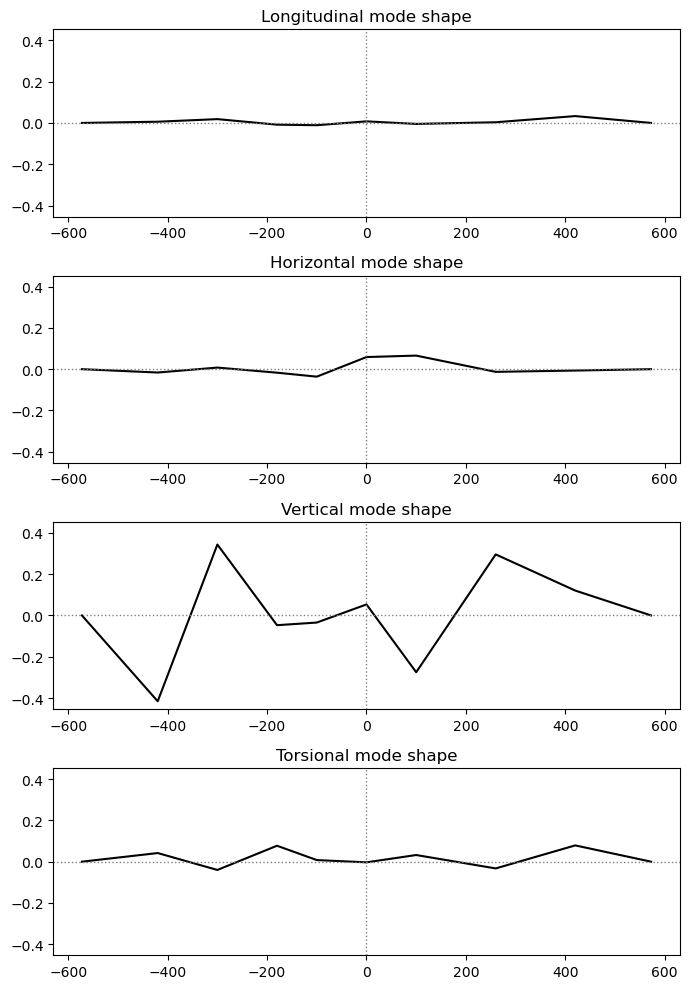

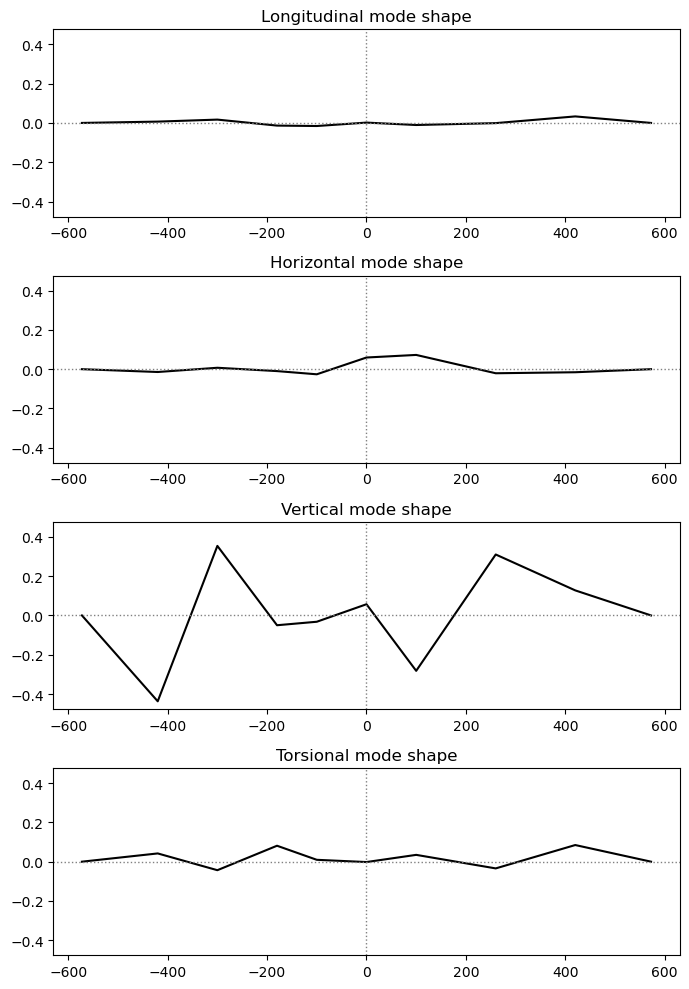

In [10]:
for i in range(phi_extracted.shape[1]):
    fig_shape = OMA.plotModeShape(phi_extracted, i)
    plt.savefig("plots/emil/modeshape_mode_" + str(i+1) + ".jpg")